In [1]:
import torch
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from math import pi
from torch import nn
import seaborn as sns
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
def data(batch_size, noise=.05):
    X, y = datasets.make_moons(n_samples=batch_size, noise=noise)
    X = StandardScaler().fit_transform(X)
    return torch.tensor(X).float()

In [3]:
class Flow(nn.Module):
    def __init__(self, seq_len, hidden, flip):
        super().__init__()
        half_seq_len = seq_len // 2
        self.log_s = nn.Sequential(
            nn.Linear(half_seq_len, hidden),
            nn.ReLU(True),
            nn.Linear(hidden, half_seq_len)
        )
        self.b = nn.Sequential(
            nn.Linear(half_seq_len, hidden),
            nn.ReLU(True),
            nn.Linear(hidden, half_seq_len)
        )
        self.flip = flip
    
    def forward(self, z):
        za, zb = z.chunk(2, dim=1)
        if self.flip:
            za, zb = zb, za
            
        log_s, b = self.log_s(za), self.b(za)
        ya = za
        yb = (zb - b) / log_s.exp()
        
        if self.flip:
            ya, yb = yb, ya
        y = torch.cat((ya, yb), dim=1)
        return y
    
    def reverse(self, y):
        ya, yb = y.chunk(2, dim=1)
        if self.flip:
            ya, yb = yb, ya

        log_s, b = self.log_s(ya), self.b(ya)
        za = ya
        zb = yb*log_s.exp() + b
        
        if self.flip:
            za, zb = zb, za
        z = torch.cat((za, zb), dim=1)
        return z, log_s

class Model(nn.Module):
    def __init__(self, d, hidden, num_flows):
        super().__init__()
        self.flows = nn.ModuleList([
            Flow(d, hidden, i%2==0)
            for i in range(num_flows)
        ])
        self.distribution = torch.distributions.MultivariateNormal(torch.zeros(d), torch.eye(d))
    
    def forward(self, batch_size):
        y = self.distribution.rsample(sample_shape=(batch_size,))
        for flow in self.flows:
            y = flow(y)
        return y
    
    def reverse(self, y):
        """This is used for training in this system"""
        z = y
        log_jacob = 0
        for flow in reversed(self.flows):
            z, ls = flow.reverse(z)
            log_jacob += ls.sum(-1)
        log_pz = self.distribution.log_prob(z)
        return z, log_pz, log_jacob

step 0000:: 3.184319496154785 [(-2.922287940979004, -0.2620313763618469)]
step 0099:: 2.2506232261657715 [(-2.890397071838379, 0.6397737264633179)]
step 0198:: 1.732259750366211 [(-2.828611373901367, 1.0963515043258667)]
step 0297:: 1.688007116317749 [(-3.109152317047119, 1.4211452007293701)]
step 0396:: 2.126852035522461 [(-2.6910059452056885, 0.5641539096832275)]
step 0495:: 1.5640819072723389 [(-2.8369362354278564, 1.2728545665740967)]
step 0594:: 1.499417781829834 [(-2.834601640701294, 1.3351837396621704)]
step 0693:: 1.4098727703094482 [(-2.772360324859619, 1.3624879121780396)]
step 0792:: 1.4671015739440918 [(-2.8564083576202393, 1.3893070220947266)]
step 0891:: 1.4384238719940186 [(-2.856703519821167, 1.418280005455017)]
step 0990:: 1.4218206405639648 [(-2.838505268096924, 1.416684865951538)]



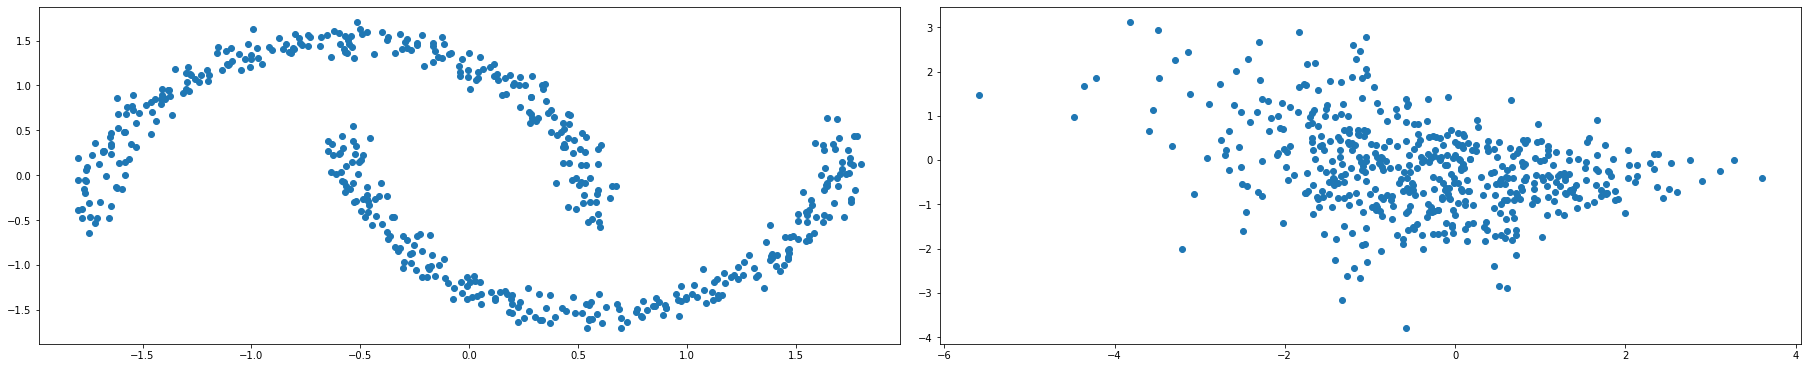

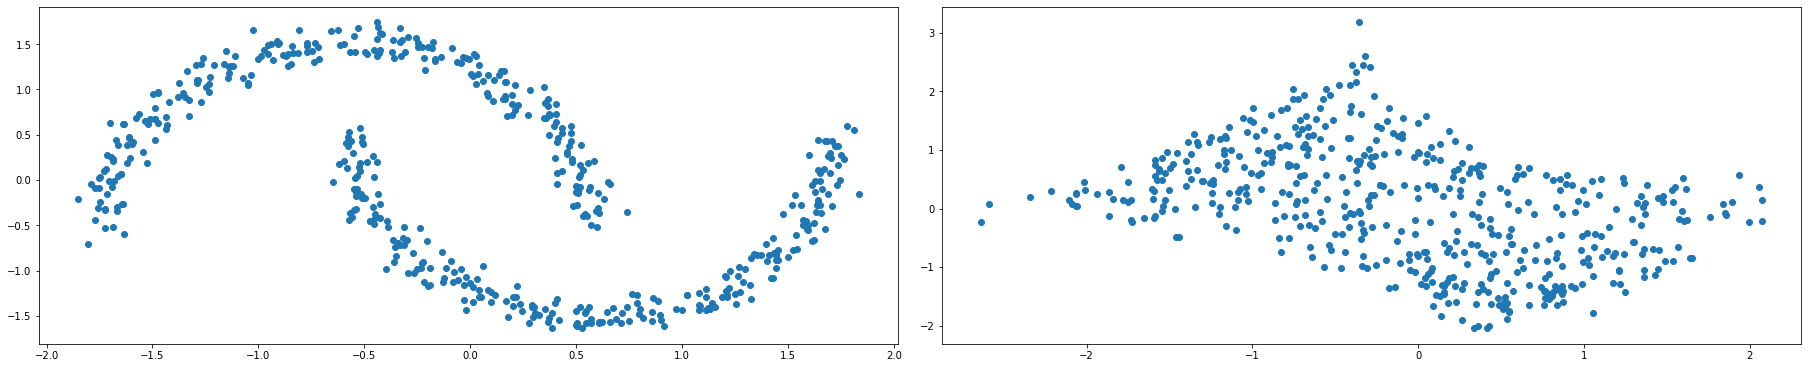

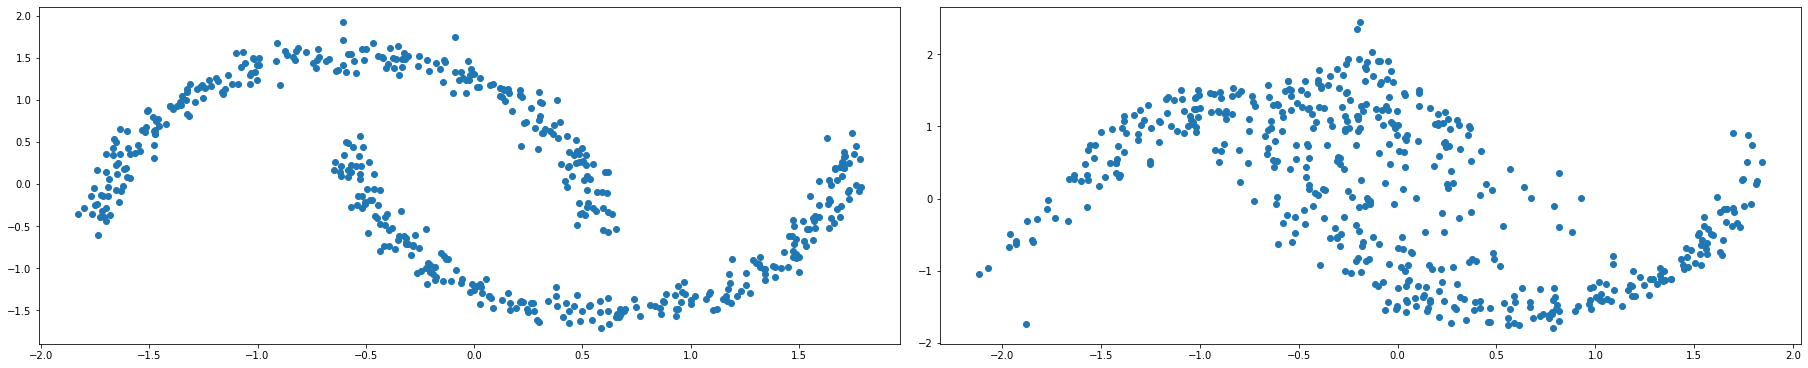

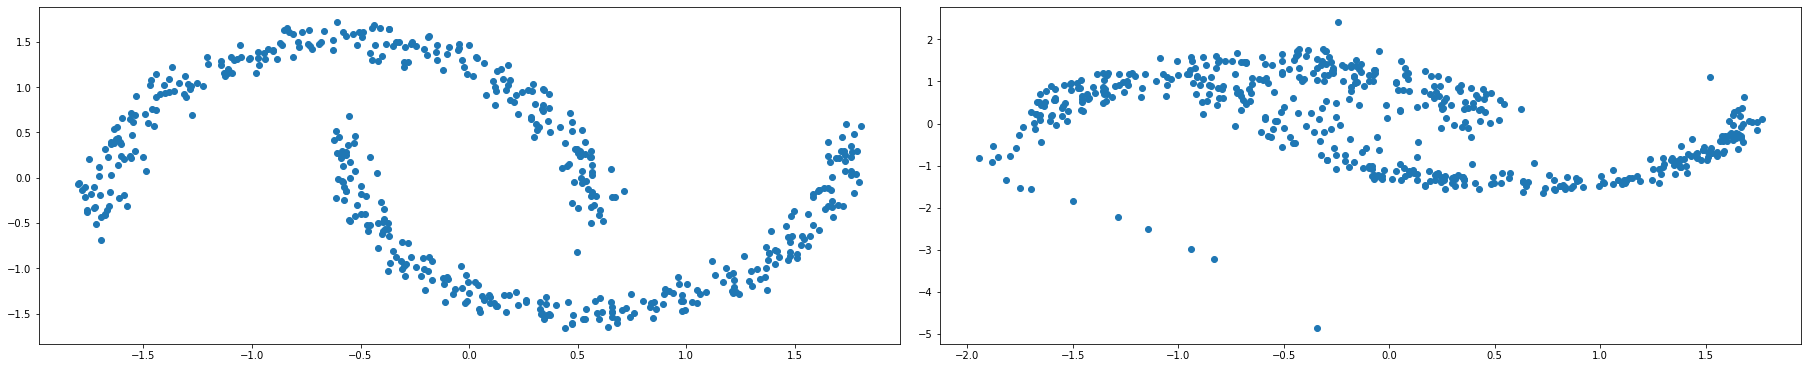

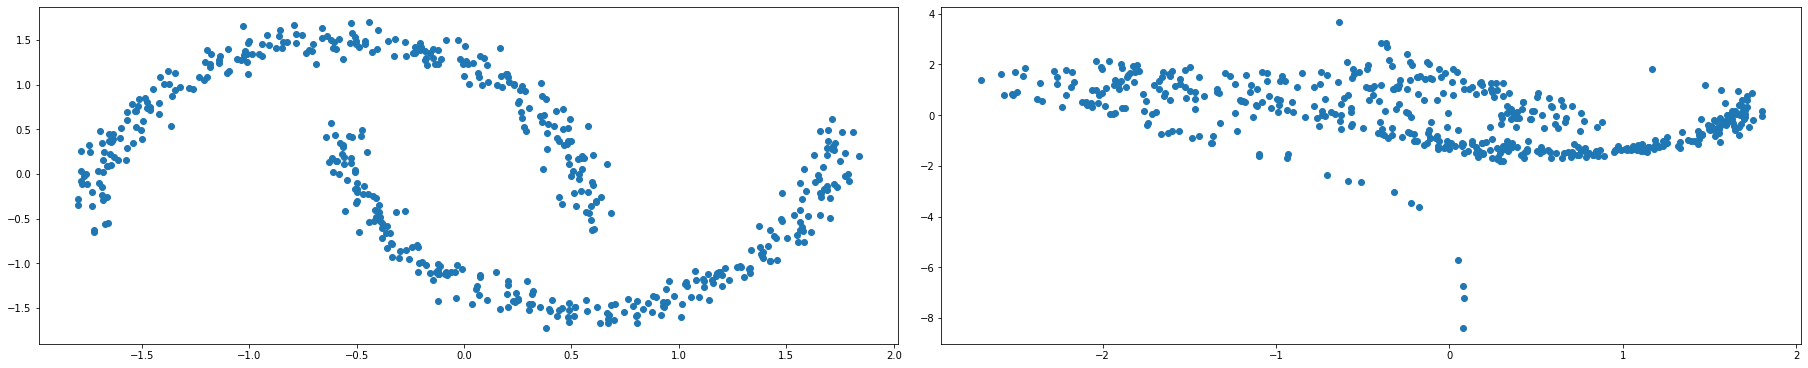

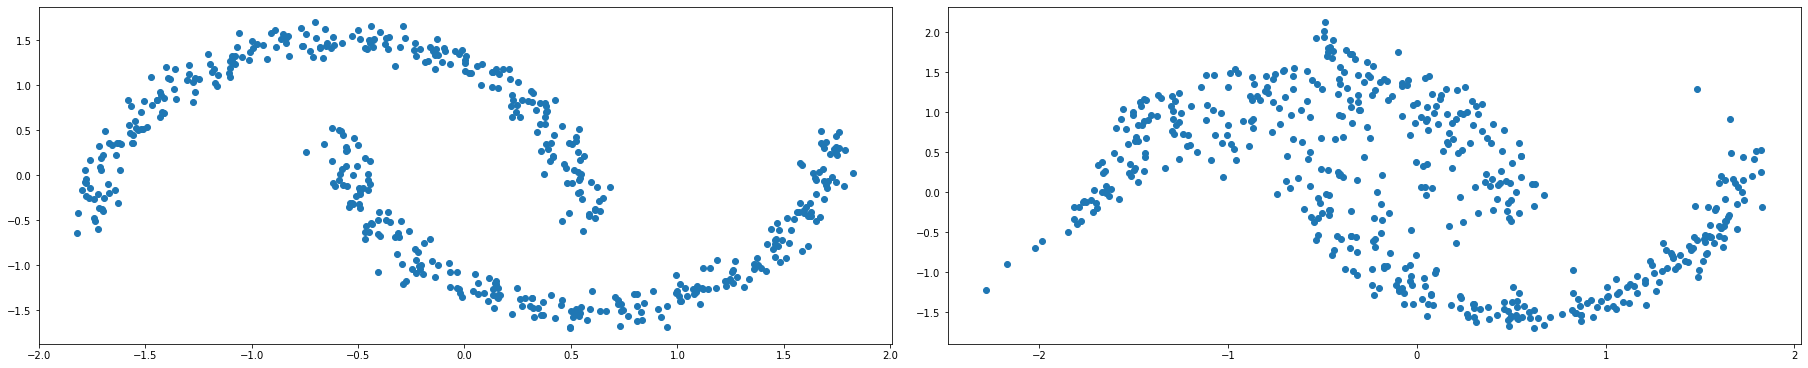

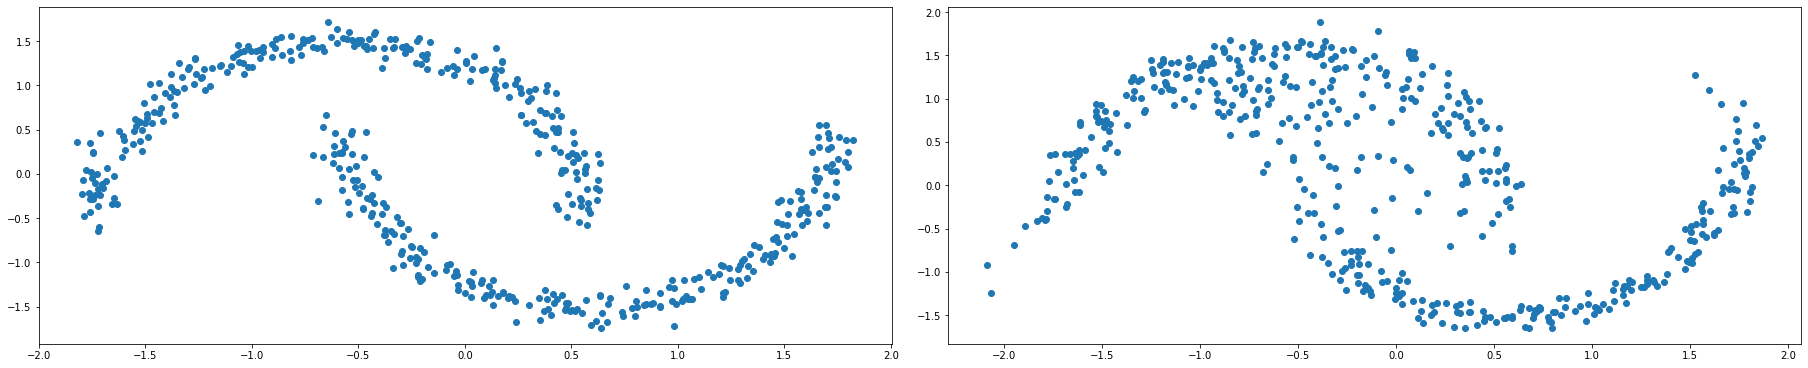

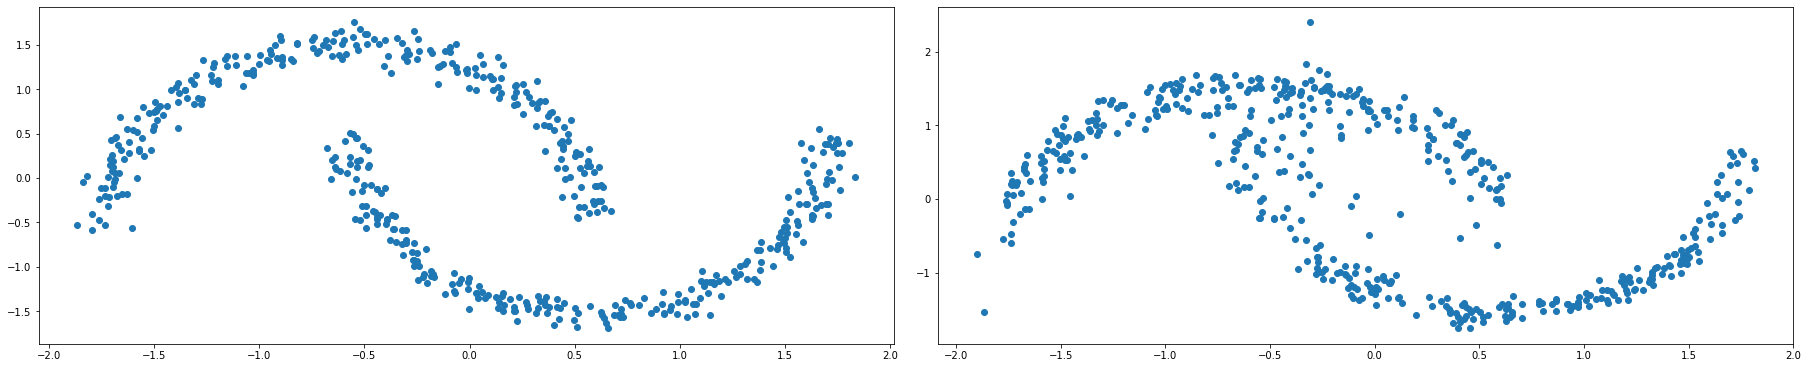

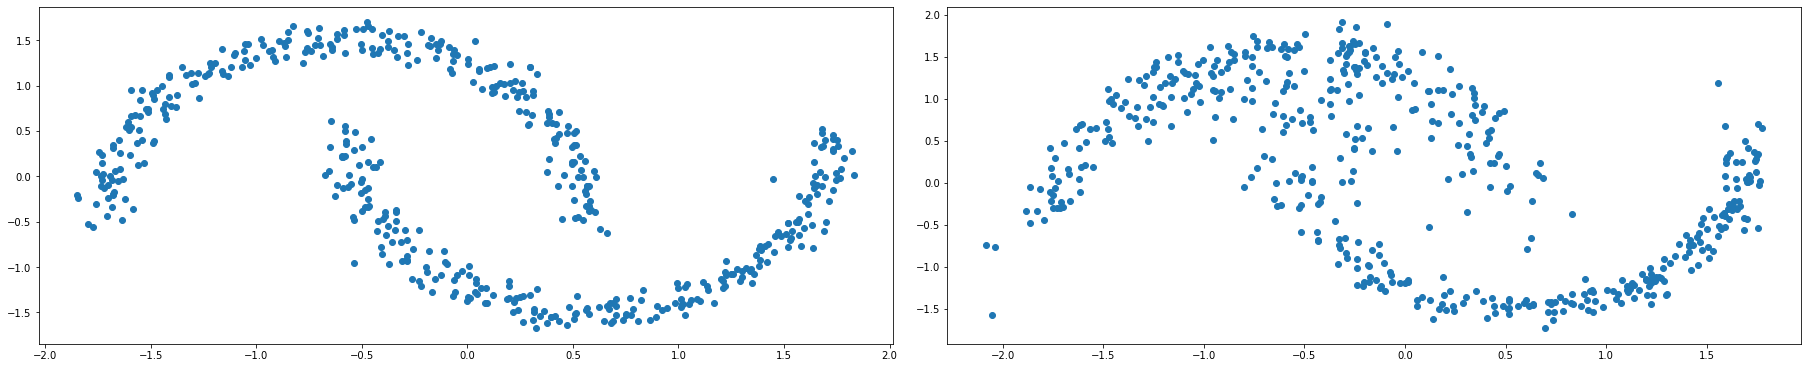

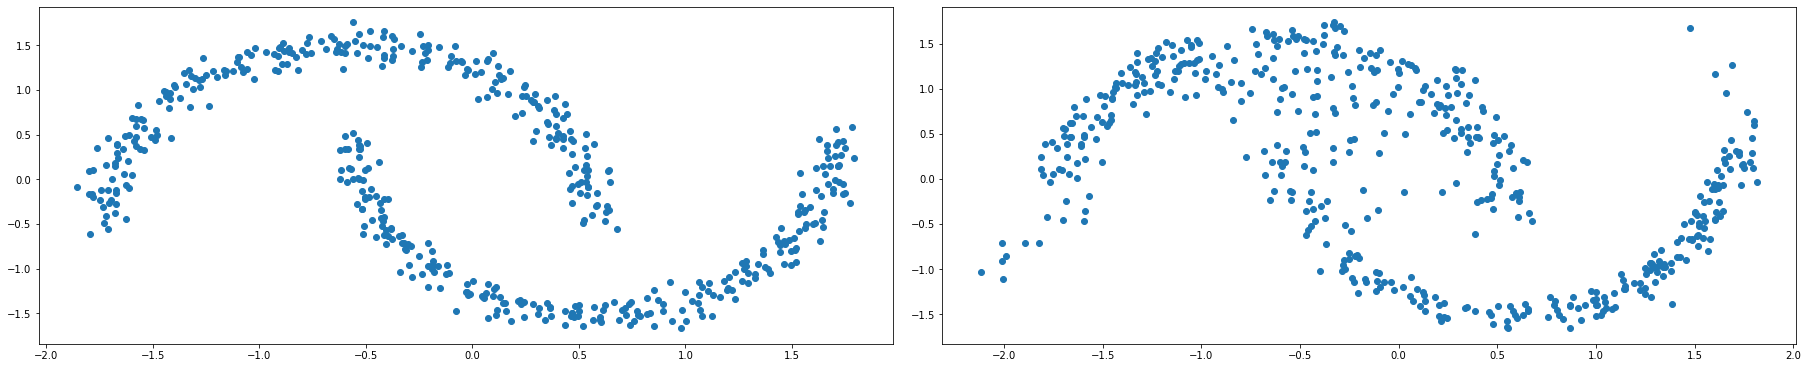

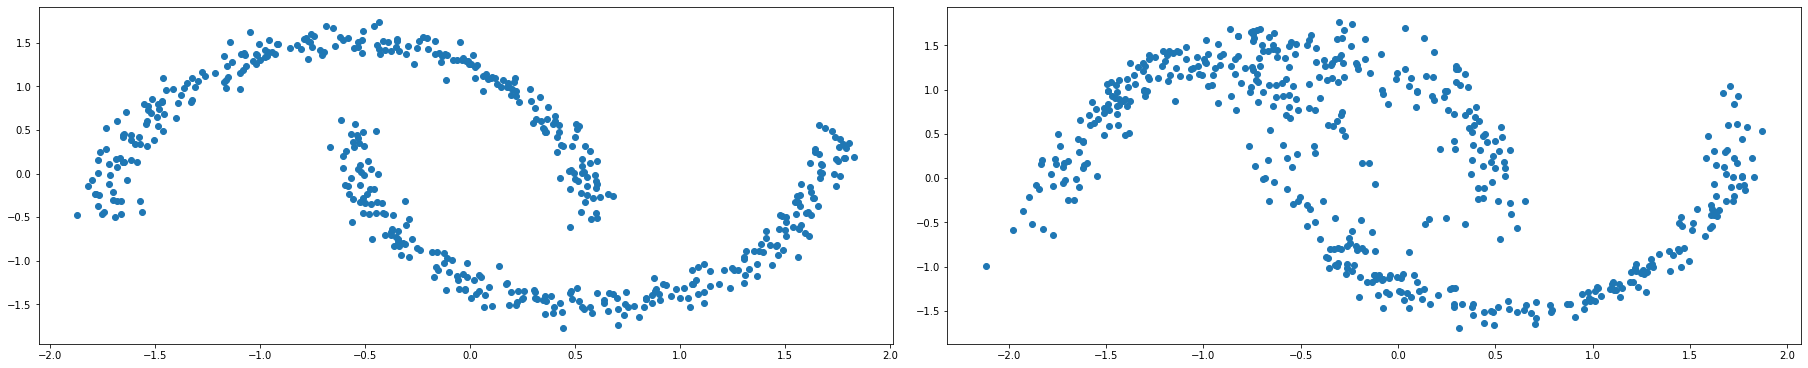

In [8]:
num_flows = 5
batch_size = 512
epochs = 1000
display_div = 99

model = Model(2, 1024, num_flows)
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

for step in tqdm(range(epochs), "Fitting"):
    optim.zero_grad()
    y = data(batch_size)
    z, log_pz, log_jacob = model.reverse(y)
    loss = (-log_pz - log_jacob).mean()
    loss.backward()
    optim.step()
    
    with torch.no_grad():
        if step % display_div == 0:
            print(f"step {step:04d}:: {loss.item()} [{log_pz.mean().item(), log_jacob.mean().item()}]")
            y2 = model.forward(batch_size)
            fig, ax = plt.subplots(1,2, figsize=(25,5), constrained_layout=True)
            ax[0].scatter(y[:, 0], y[:, 1])
            ax[1].scatter(y2[:, 0], y2[:, 1])
            fig.show()